In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForTokenClassification
from datasets import Dataset
import matplotlib.pyplot as plt
import pandas as pd

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [122]:
def get_predicted_label(model, tokenizer, sentences, id2label, batch_size=16):
  y_pred = []

  with torch.no_grad():
    for i in range(0, len(sentences), batch_size):
      batch = sentences[i:i+batch_size]

      # 토큰화
      inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
      inputs = {k:v.to(device) for k,v in inputs.items()}

      outputs = model(**inputs)
      logits = outputs.logits
      preds = torch.argmax(logits, dim=2)

      for j, sentence in enumerate(batch):
        input_ids = inputs["input_ids"][j]
        pred_labels = [id2label[p.item()] for p in preds[j][:len(input_ids)]]
        y_pred.append(pred_labels)

  return y_pred


In [123]:
model_dir = "/content/drive/MyDrive/ner_kc_electra_final"

In [124]:
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForTokenClassification.from_pretrained(model_dir).to(device)

In [125]:
model.eval()

ElectraForTokenClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [126]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ner_dataset_motsunabe.csv")

# sentence_id 기준으로 문장별 input_ids, labels 리스트 만들기
grouped = df.groupby("sentence_id")
input_ids = grouped["token_id"].apply(list).tolist()[:111]
labels = grouped["tag"].apply(list).tolist()[:111]

# label → 숫자 인덱스로 변환
unique_labels = sorted(set(l for doc in labels for l in doc))
label2id = {l: i for i, l in enumerate(unique_labels)}
id2label = {i: l for l, i in label2id.items()}
labels_ids = [[label2id[l] for l in doc] for doc in labels]

dataset = []
for idx, ids in enumerate(input_ids):
  dataset.append(tokenizer.decode(ids)[6:-6])

In [127]:
y_pred = get_predicted_label(model, tokenizer, dataset, id2label)

In [133]:
import numpy as np

def plot_confusion_matrix(y_pred, y_true, labels):
  y_true = [y for x in y_true for y in x]
  y_pred = [y for x in y_pred for y in x]

  print(y_true)
  print(y_pred)

  cm = confusion_matrix(y_true, y_pred, normalize="true")

  print(cm.shape)

  fig, ax = plt.subplots(figsize=(9,9))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [129]:
label2id

{'B-AMB': 0,
 'B-EXP': 1,
 'B-MENU': 2,
 'B-PP': 3,
 'I-AMB': 4,
 'I-EXP': 5,
 'I-MENU': 6,
 'I-PP': 7,
 'O': 8}

In [130]:
tags = ['B-AMB','B-EXP','B-MENU','B-PP','I-AMB','I-EXP','I-MENU','I-PP','O']

In [131]:
for idx, label in enumerate(labels):
  label.extend(['O'] * (len(y_pred[idx]) - len(label)))

['O', 'O', 'O', 'O', 'O', 'B-MENU', 'I-MENU', 'I-MENU', 'I-MENU', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MENU', 'I-MENU', 'I-MENU', 'I-MENU', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PP', 'O', 'B-MENU', 'I-MENU', 'I-MENU', 'I-MENU', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MENU', 'I-MENU', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

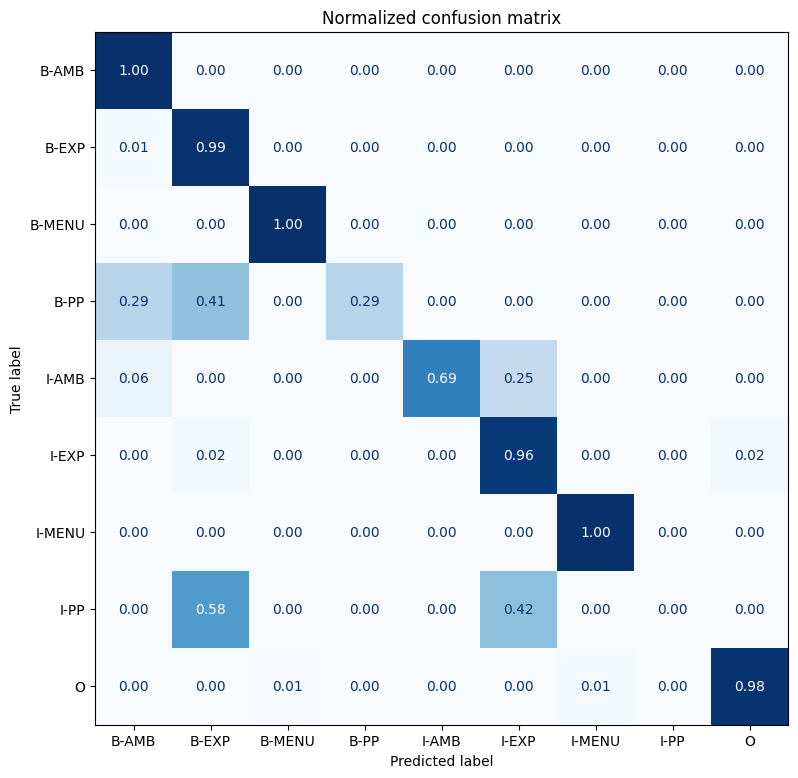

In [134]:
plot_confusion_matrix(y_pred, labels, tags)